In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA

sns.set_context('poster')
sns.set_style('white')

pd.options.mode.chained_assignment = None  # default='warn'

import hdbscan
from collections import Counter
from collections import defaultdict
from numpy import random

In [24]:
def normalize(x, r):
    M = np.divide(x, r)
    M_norm = np.full_like(M, 0)
    for i in range(np.shape(M)[0]):
        rev = 1 - M[i, :]
        if np.dot(M[i, :], M[i, :]) > np.dot(rev, rev):
            M_norm[i, :] = rev
        else:
            M_norm[i, :] = M[i, :]
    return M_norm

f = normalize(x, r)

In [2]:
def draw_PCA(f_pca, black_points=None):
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=10, linewidth=0, alpha=0.2);
    if black_points is not None:
        plt.scatter(f_pca[black_points, 0], f_pca[black_points, 1], s=10, linewidth=0, c="black", alpha=1);
        plt.title("%s/%s points" % (np.sum(black_points), len(f_pca)))
    else:
        plt.title("%s points" % len(f_pca))

In [3]:
def filter_by_coverage(cur_r, bad_percent, bad_samples):
    def filter_row(row):
        num_of_samples = len(row)
        valid = np.sum(np.array(([(min_coverage < row) & (row < max_coverage)])))
        return num_of_samples - valid <= bad_samples

    min_coverage = np.percentile(cur_r, bad_percent, axis=0)
    max_coverage = np.percentile(cur_r, 100-bad_percent, axis=0)
    good_coverage = np.array([filter_row(row) for row in cur_r])
    return good_coverage

(Вспомогательная процедура, которая рисует легенду с обозначением цветов.)

In [4]:
def draw_legend(class_colours, classes, right=False):
    recs = []
    for i in range(0, len(classes)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    if right:
        plt.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(recs, classes)

SNP, встречающиеся в комбинации стрейнов

In [5]:
 def plot_shared_snps(f_pca, mask, names, draw_all=False):
    combs = []
    combs_nums = []
    combinations = []

    for m in mask:
        if not draw_all:
            if not (np.sum(m) > 1):
                combinations.append(-1)
                continue
        cur = ""
        for i in range(len(m)):
            if m[i] == 1:
                if cur != "":
                    cur += " + "
                cur += names[i] 
        if cur == "":
            cur = "none"                   
        if cur not in combs:
            combs.append(cur)
            combs_nums.append(0)
        combs_nums[combs.index(cur)] += 1
        combinations.append(combs.index(cur))

    df = pd.DataFrame({'pc1':f_pca[:, 0], 'pc2':f_pca[:, 1], 'combination':combinations})
    df_valid = df.loc[df['combination'] != -1]

    # reoder combinations by sizes of groups
    order = sorted(zip(combs_nums, combs, range(12)), reverse=True)
    new_comb_order = [0] * (2 ** len(mask[0]))
    new_comb_names = [] 
    for i in range(len(order)):
        old_order = order[i][2]
        new_comb_order[old_order] = i
        new_comb_names.append('{:5d}'.format(order[i][0]) + '  ' + order[i][1])
    for i in df_valid.index:
        df_valid.loc[i, "combination"] = new_comb_order[df_valid.loc[i, "combination"]]

    # Kelly’s 20 (except the first 2) Colours of Maximum Contrast
    colors = ['yellow', 'purple', 'orange', '#96cde6', 'red', '#c0bd7f', '#7f7e80', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']
    color_palette = sns.color_palette(colors)
    cluster_colors = [color_palette[x] for x in df_valid["combination"]]

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.scatter(df_valid["pc1"], df_valid["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.6);
    draw_legend(color_palette, new_comb_names, right=True)

In [6]:
def sizes_to_probs(s):
    s_log = np.log(s)
    return s_log / s_log.sum()


def subsample_from_cluters(Npoints, labels):
    groupby_labels = defaultdict(list)
    for i in range(len(labels)):
        groupby_labels[labels[i]].append(i)
    groupby_labels = dict(groupby_labels)

    cluster_size = np.array([len(groupby_labels[i]) for i in groupby_labels.keys()], dtype=int)
    print("exemplars sizes:")
    print(list(cluster_size), "\n")
    cluster_size = Npoints * sizes_to_probs(cluster_size)
    print("subsamplings sizes:")
    print([int(round(s)) for s in cluster_size], "\n")

    subsamples = {}
    for i in groupby_labels.keys():
        subsample_size = int(round(cluster_size[i]))
        subsample_index = random.choice(groupby_labels[i], size=subsample_size, replace=True).tolist()
        subsamples[i] = subsample_index

    ind = [val for sublist in list(subsamples.values()) for val in sublist]
    random.shuffle(ind)
    return ind


# search indexes of exemplars in data
def indexes_of_rows(f, exemplars):
    f_sorted = np.ascontiguousarray(f).view([('', f.dtype)] * f.shape[-1]).ravel()
    f_sorted.sort()
    exemplars_comp = np.ascontiguousarray(exemplars).view(f_sorted.dtype)
    exemplars_ind = f_sorted.searchsorted(exemplars_comp)
    exemplars_ind = exemplars_ind.flatten()
    exemplars_ind.sort()
    return exemplars_ind


def clusterization(f, pca=True, num_of_comp=2):
    
    if pca:
        f_pca = PCA(n_components = num_of_comp).fit(f).transform(f)
        cur_f = f_pca
        f_sorted = np.ascontiguousarray(f_pca).view([('', f_pca.dtype)] * f_pca.shape[-1]).ravel()
        f_sorted.sort()
    else:
        cur_f = f
        f_sorted = np.ascontiguousarray(f).view([('', f.dtype)] * f.shape[-1]).ravel()
        f_sorted.sort()
        f_pca = PCA(n_components = 2).fit(f).transform(f)
        # print(locals())
    
    #N = (nt) (len(f) * 0.005)
    #print(N)
    N = 100

    clusterer = hdbscan.HDBSCAN(min_cluster_size=N, min_samples=1).fit(cur_f)
    
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    if pca:
        plt.title("Clustering %s primary components" % num_of_comp)
    else:
        plt.title("Clustering initial frequencies")
        
    
    color_palette = sns.color_palette("Set2", 20)
    cluster_colors = [color_palette[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clusterer.probabilities_)]
    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=40, linewidth=0, c=cluster_member_colors, alpha=0.3);
    
    exemplars_ind = indexes_of_rows(cur_f, np.concatenate(clusterer.exemplars_))
    
    plt.scatter(f_pca[exemplars_ind, 0], f_pca[exemplars_ind, 1], s=7, linewidth=0, c="black", alpha=0.9);
    
    f_filtered_pca = f_pca[exemplars_ind]
    r_filtered = r[exemplars_ind]
    x_filtered = x[exemplars_ind]
    subs_ind = subsample_from_cluters(200, clusterer.labels_[exemplars_ind])
    #plt.scatter(f_filtered_pca[subs_ind, 0], f_filtered_pca[subs_ind, 1], s=10, linewidth=0, c="black", alpha=1)
    
    np.savetxt("R_filtered", r_filtered[subs_ind, :], fmt='%s')
    np.savetxt("X_filtered", x_filtered[subs_ind, :], fmt='%s')
    
    sizes_of_classes = Counter(clusterer.labels_)
    print(sizes_of_classes.get(-1, 0), "outliers\n")
    labels = [str(x) + ' - ' + str(sizes_of_classes[x]) for x in range(max(clusterer.labels_)+1)]
    draw_legend(color_palette, labels, right=True)
    
    print("Medians in exemplars:")
    for i in range(max(clusterer.labels_)+1):
        cur_ind = indexes_of_rows(cur_f, clusterer.exemplars_[i])
        print(i, np.round(np.median(f[cur_ind], axis=0), 2))     

# Infant Gut, выровненный на Strain 1
(Преобразование не делаем, так как референс есть в данных)

##### Частоты стрейнов в Infant Gut:

strain1 0.73 0.74 0.04 0.13 0.17 0.04 0.32 0.75 0.30 0.20 0.0

strain2 0.24 0.20 0.95 0.80 0.80 0.93 0.52 0.19 0.64 0.65 1.0

strain3 0.03 0.06 0.02 0.07 0.03 0.02 0.16 0.06 0.06 0.15 0.0

In [7]:
r = np.genfromtxt("infant_gut_pure_STRAIN1/matrices/R_all", dtype=int, delimiter=' ')
x = np.genfromtxt("infant_gut_pure_STRAIN1/matrices/X_all", dtype=int, delimiter=' ')
names = ["strain 1", "strain 3", "strain 4"]
num_of_strains = len(names)

print("%s sites" % len(r))

53584 sites


Читаем маску и удаляем первые 4 колонки:

In [8]:
mask = x[:, 0:num_of_strains]
mask[mask > 0] = 1
r = np.delete(r, [i for i in range(num_of_strains)], axis=1)
x = np.delete(x, [i for i in range(num_of_strains)], axis=1)

Удаляем снипы с покрытием, близким к 0 или 1:

In [16]:
Ncut = 5
print("Delete zero and almost zero profiles:")
good_ind = [i for i in range(np.shape(x)[0]) 
            if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
print(len(good_ind), "remained")

x = x[good_ind, :]
r = r[good_ind, :]
mask = mask[good_ind, :]

Delete zero and almost zero profiles:
13625 remained


Рисуем получившиеся фичи на главных компонентах и отмечаем те точки, у которых неплохое покрытие по R. 

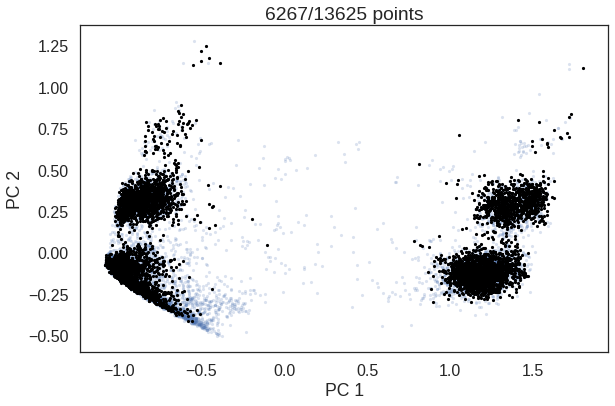

In [10]:
f = np.divide(x, r)
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca, filter_by_coverage(r, 15, 2))

Оставляем только точки с хорошим покрытием.

In [11]:
good_coverage = filter_by_coverage(r, 15, 2)
mask_filtered = mask[good_coverage, :]

f_withoutT_filtered = np.divide(x, r)[good_coverage, :]
f_pca_withoutT_filtered = PCA(n_components=2).fit(f_withoutT_filtered).transform(f_withoutT_filtered)

Смотрим, какой снип кому соответствует.

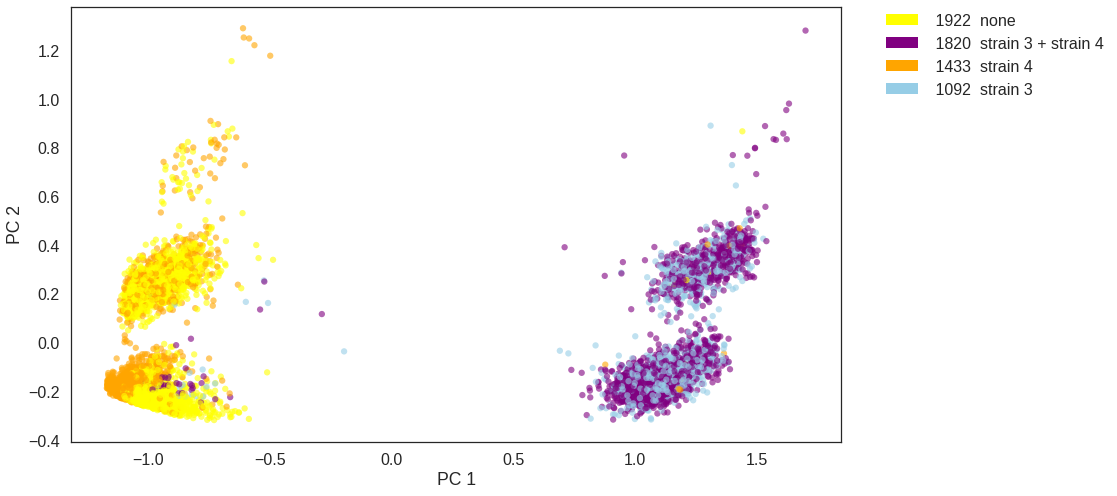

In [12]:
plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names, draw_all=True)

Кластеризация так и сяк.

exemplars sizes:
[439, 206] 

subsamplings sizes:
[107, 93] 

0 outliers

Medians in exemplars:
0 [ 0.23  0.2   1.    0.88  0.88  0.95  0.61  0.18  0.65  0.76  0.98]
1 [ 0.01  0.01  0.    0.    0.01  0.01  0.    0.01  0.    0.03  0.  ]


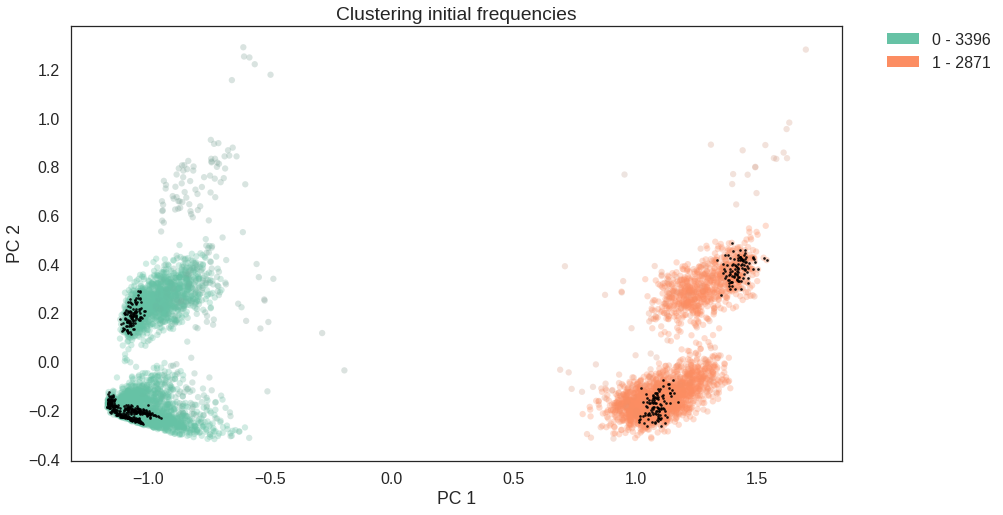

In [13]:
clusterization(f_withoutT_filtered, pca=False)

exemplars sizes:
[421, 233, 258, 232] 

subsamplings sizes:
[54, 48, 49, 48] 

133 outliers

Medians in exemplars:
0 [ 0.09  0.08  0.82  0.68  0.64  0.74  0.34  0.07  0.51  0.55  0.89]
1 [ 0.01  0.01  0.    0.01  0.01  0.04  0.1   0.01  0.01  0.15  0.04]
2 [ 0.5   0.36  0.95  0.83  0.9   0.92  0.54  0.36  0.65  0.73  0.96]
3 [ 0.25  0.22  0.04  0.08  0.16  0.06  0.14  0.22  0.11  0.14  0.02]


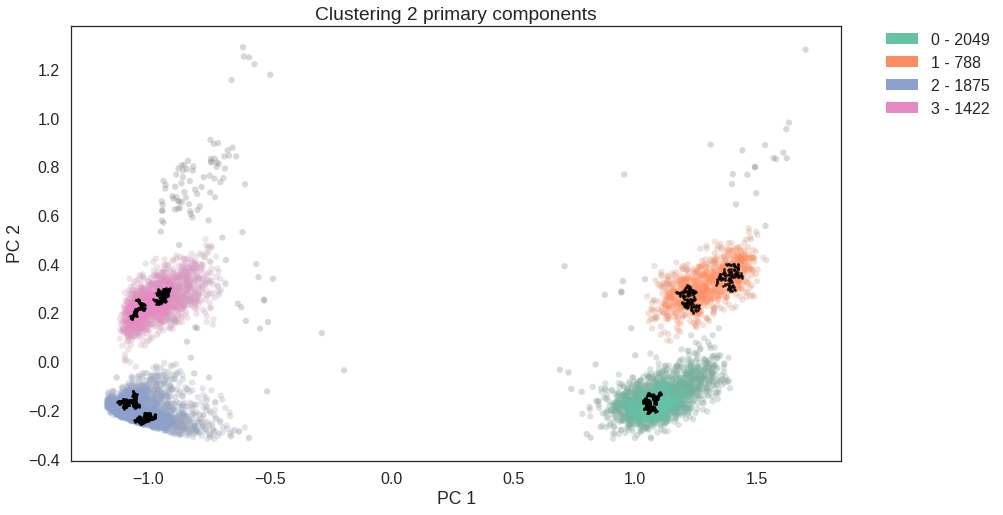

In [14]:
clusterization(f_withoutT_filtered, pca=True, num_of_comp=2)

exemplars sizes:
[478, 119, 103, 101] 

subsamplings sizes:
[61, 47, 46, 46] 

293 outliers

Medians in exemplars:
0 [ 0.01  0.01  0.    0.    0.01  0.04  0.08  0.01  0.    0.2   0.05]
1 [ 0.01  0.01  0.    0.    0.01  0.06  0.12  0.01  0.01  0.23  0.07]
2 [ 0.55  0.41  1.    0.88  0.92  0.95  0.65  0.39  0.7   0.81  0.98]
3 [ 0.25  0.22  0.05  0.09  0.19  0.09  0.18  0.2   0.12  0.18  0.03]


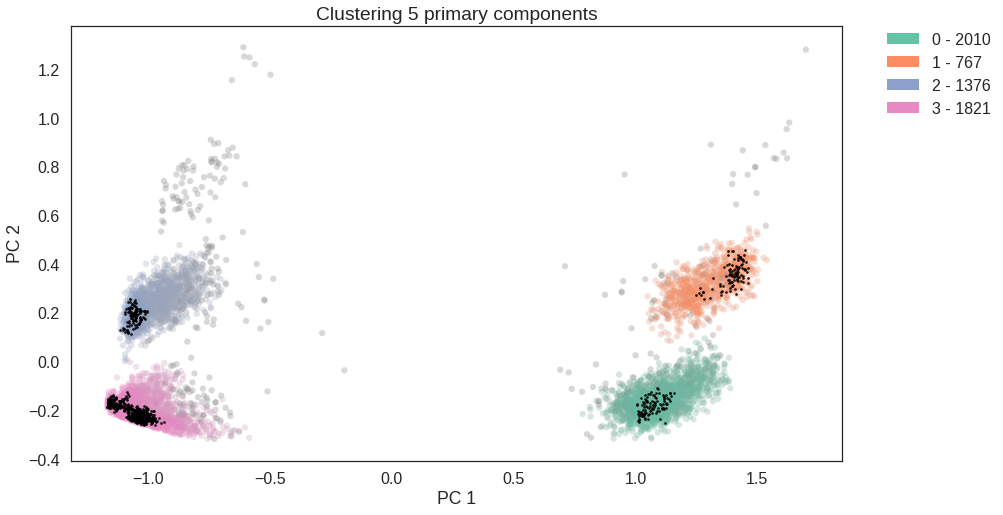

In [15]:
clusterization(f_withoutT_filtered, pca=True, num_of_comp=5)

# Infant Gut Trimmed, выровненный на Strain 1
(То же самое, только риды пообрезали по качеству.)

In [17]:
r = np.genfromtxt("infant_gut_pure_STRAIN1_trimmed/matrices/R_all", dtype=int, delimiter=' ')
x = np.genfromtxt("infant_gut_pure_STRAIN1_trimmed/matrices/X_all", dtype=int, delimiter=' ')
names = ["strain 1", "strain 3", "strain 4"]
num_of_strains = len(names)

print("%s sites" % len(r))

53532 sites


In [18]:
mask = x[:, 0:num_of_strains]
mask[mask > 0] = 1
r = np.delete(r, [i for i in range(num_of_strains)], axis=1)
x = np.delete(x, [i for i in range(num_of_strains)], axis=1)

In [19]:
Ncut = 5
print("Delete zero and almost zero profiles:")
good_ind = [i for i in range(np.shape(x)[0]) 
            if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
print(len(good_ind), "remained")

x = x[good_ind, :]
r = r[good_ind, :]
mask = mask[good_ind, :]

Delete zero and almost zero profiles:
13620 remained


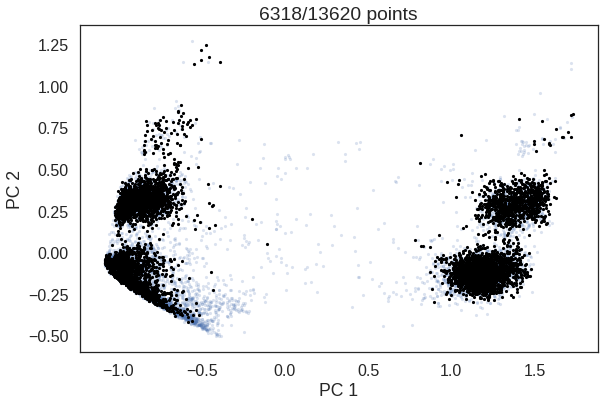

In [20]:
f = np.divide(x, r)
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca, filter_by_coverage(r, 15, 2))

In [21]:
good_coverage = filter_by_coverage(r, 15, 2)
mask_filtered = mask[good_coverage, :]

f_withoutT_filtered = np.divide(x, r)[good_coverage, :]
f_pca_withoutT_filtered = PCA(n_components=2).fit(f_withoutT_filtered).transform(f_withoutT_filtered)

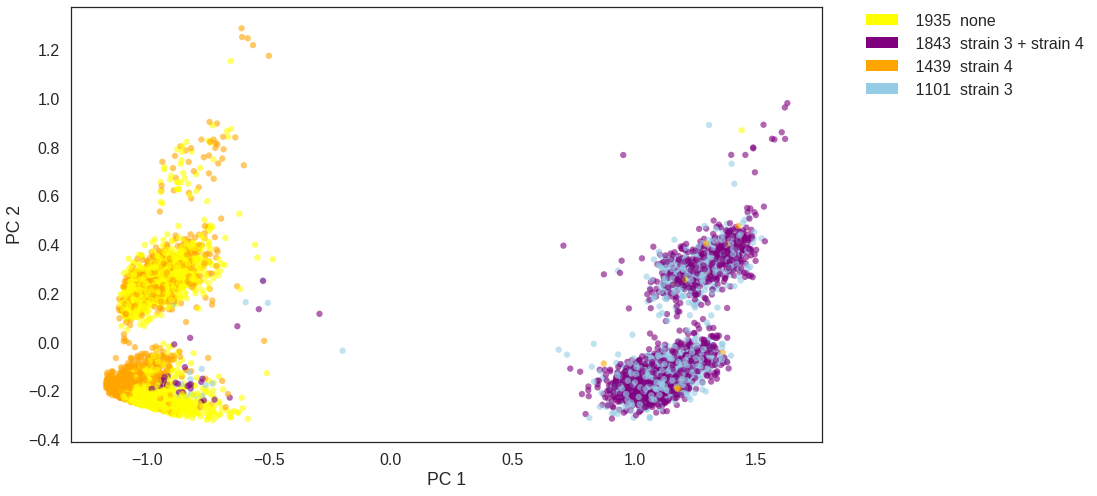

In [22]:
plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names, draw_all=True)

В общем, не отличается почти. Дальше не буду рассматривать этот датасет.

# Infant Gut, выровненный на референс NCBI
(Здесь делаем преобразование.)

In [25]:
r = np.genfromtxt("infant_gut_pure_without_ref/matrices/R_all", dtype=int, delimiter=' ')
x = np.genfromtxt("infant_gut_pure_without_ref/matrices/X_all", dtype=int, delimiter=' ')
names = ["strain 1", "strain 3", "strain 4"]
num_of_strains = len(names)

print("%s sites" % len(r))

54466 sites


In [26]:
mask = x[:, 0:num_of_strains]
mask[mask > 0] = 1
r = np.delete(r, [i for i in range(num_of_strains)], axis=1)
x = np.delete(x, [i for i in range(num_of_strains)], axis=1)

In [27]:
Ncut = 5
print("Delete zero and almost zero profiles:")
good_ind = [i for i in range(np.shape(x)[0]) 
            if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
print(len(good_ind), "remained")

x = x[good_ind, :]
r = r[good_ind, :]
mask = mask[good_ind, :]

Delete zero and almost zero profiles:
14115 remained


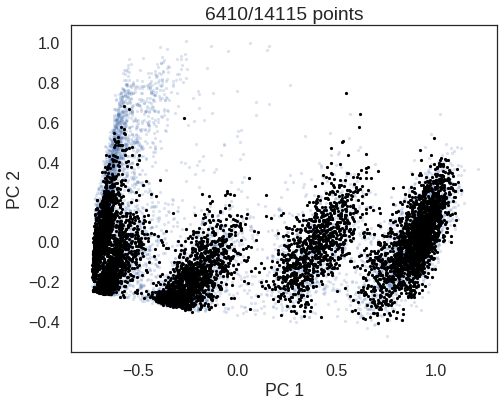

In [28]:
f = normalize(x, r)
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca, filter_by_coverage(r, 15, 2))

In [29]:
good_coverage = filter_by_coverage(r, 15, 2)
mask_filtered = mask[good_coverage, :]

f_filtered = normalize(x, r)[good_coverage, :]
f_pca_filtered = PCA(n_components=2).fit(f_filtered).transform(f_filtered)

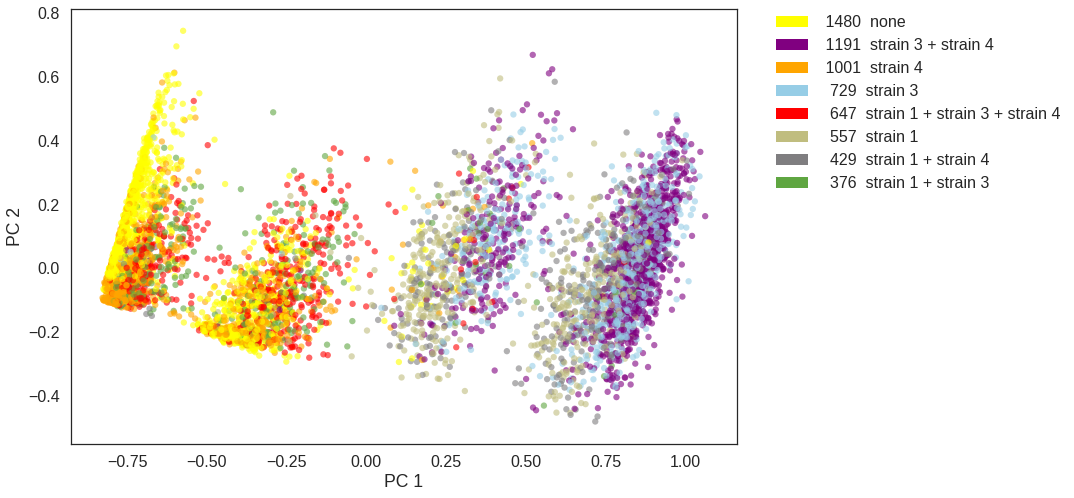

In [30]:
plot_shared_snps(f_pca_filtered, mask_filtered, names, draw_all=True)

Если же преобразование не делать...

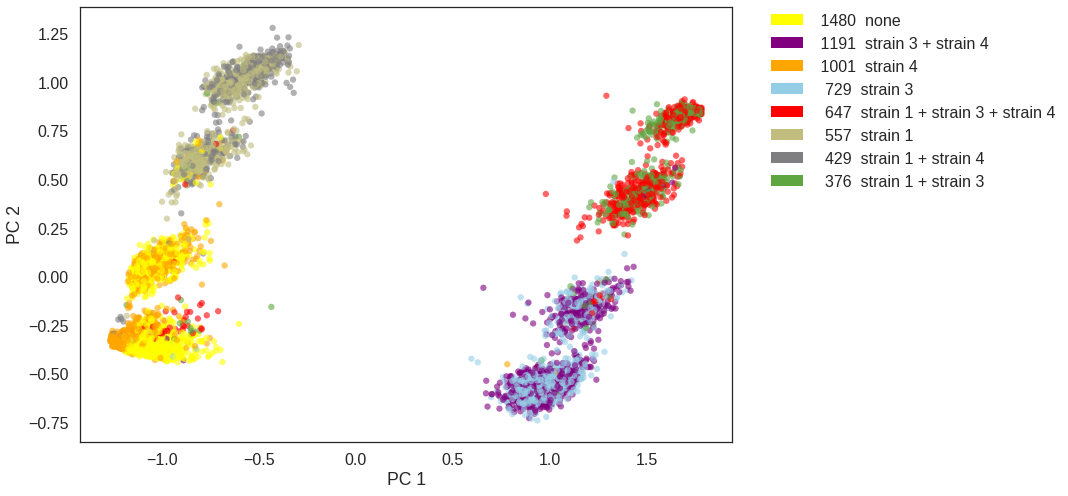

In [33]:
f_withoutT_filtered = np.divide(x, r)[good_coverage, :]
f_pca_withoutT_filtered = PCA(n_components=2).fit(f_withoutT_filtered).transform(f_withoutT_filtered)

plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names, draw_all=True)

exemplars sizes:
[308, 110, 303] 

subsamplings sizes:
[71, 58, 71] 

621 outliers

Medians in exemplars:
0 [ 0.01  0.    0.    0.    0.    0.01  0.    0.    0.    0.02  0.  ]
1 [ 0.26  0.2   0.    0.03  0.1   0.    0.    0.23  0.03  0.03  0.  ]
2 [ 0.83  0.86  0.    0.16  0.19  0.06  0.4   0.88  0.38  0.3   0.02]


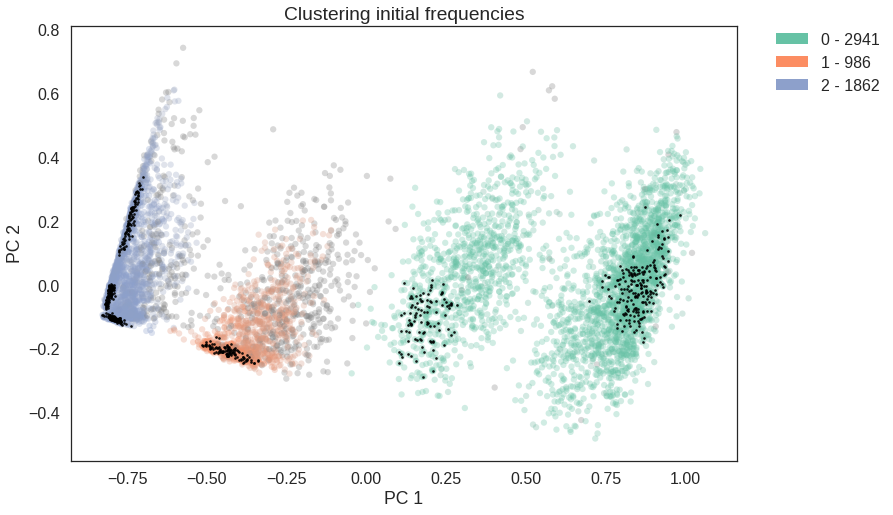

In [34]:
clusterization(f_filtered, pca=False)

exemplars sizes:
[409, 267, 100, 138, 102, 100] 

subsamplings sizes:
[40, 37, 30, 32, 30, 30] 

61 outliers

Medians in exemplars:
0 [ 0.82  0.81  0.04  0.13  0.18  0.03  0.33  0.84  0.3   0.22  0.02]
1 [ 0.5   0.58  0.    0.09  0.04  0.01  0.25  0.59  0.25  0.12  0.  ]
2 [ 0.97  0.96  1.    1.    0.97  0.98  1.    0.98  0.94  0.97  1.  ]
3 [ 0.67  0.75  1.    0.94  0.86  0.98  0.94  0.75  0.93  0.9   0.99]
4 [ 0.01  0.01  0.    0.01  0.01  0.01  0.    0.01  0.    0.03  0.  ]
5 [ 0.17  0.14  1.    0.83  0.82  0.92  0.56  0.12  0.62  0.69  0.97]


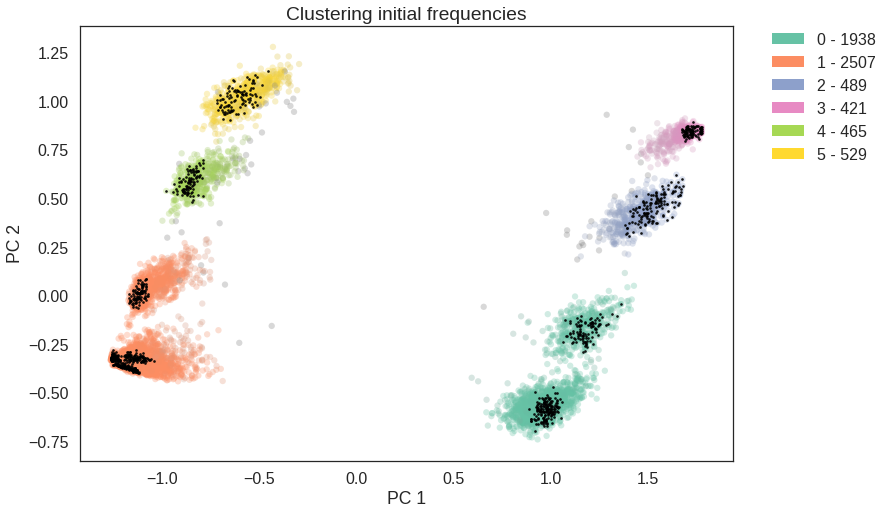

In [35]:
clusterization(f_withoutT_filtered, pca=False)

# Синтетический датасет из 2 склеенных SRA, выровненный на сборку одного из них

Первые 2 образца -- просто библиотеки полногеномного секвенирования соответствующих бактерий.

Далее смешивались риды из двух библиотек в пропорциях 10:90, 20:80 и так далее до 90:10.

In [36]:
r = np.genfromtxt("sim_ncbi_ga_2strains/matrices/R_all", dtype=int, delimiter=' ')
x = np.genfromtxt("sim_ncbi_ga_2strains/matrices/X_all", dtype=int, delimiter=' ')
names = ["JJ2434", "SaT040"]
num_of_strains = len(names)

print("%s sites" % len(r))

6716 sites


In [37]:
mask = x[:, 0:num_of_strains]
mask[mask > 0] = 1
r = np.delete(r, [i for i in range(num_of_strains)], axis=1)
x = np.delete(x, [i for i in range(num_of_strains)], axis=1)

In [38]:
Ncut = 5
print("Delete zero and almost zero profiles:")
good_ind = [i for i in range(np.shape(x)[0]) 
            if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
print(len(good_ind), "remained")

x = x[good_ind, :]
r = r[good_ind, :]
mask = mask[good_ind, :]

Delete zero and almost zero profiles:
6647 remained


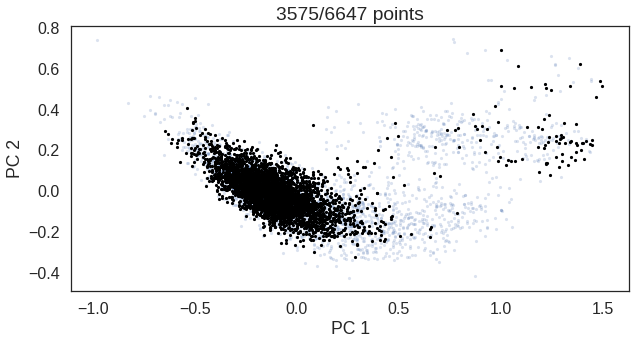

In [52]:
f = np.divide(x, r)
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca, filter_by_coverage(r, 15, 2))

In [53]:
good_coverage = filter_by_coverage(r, 15, 2)
mask_filtered = mask[good_coverage, :]

f_withoutT_filtered = np.divide(x, r)[good_coverage, :]
f_pca_withoutT_filtered = PCA(n_components=2).fit(f_withoutT_filtered).transform(f_withoutT_filtered)

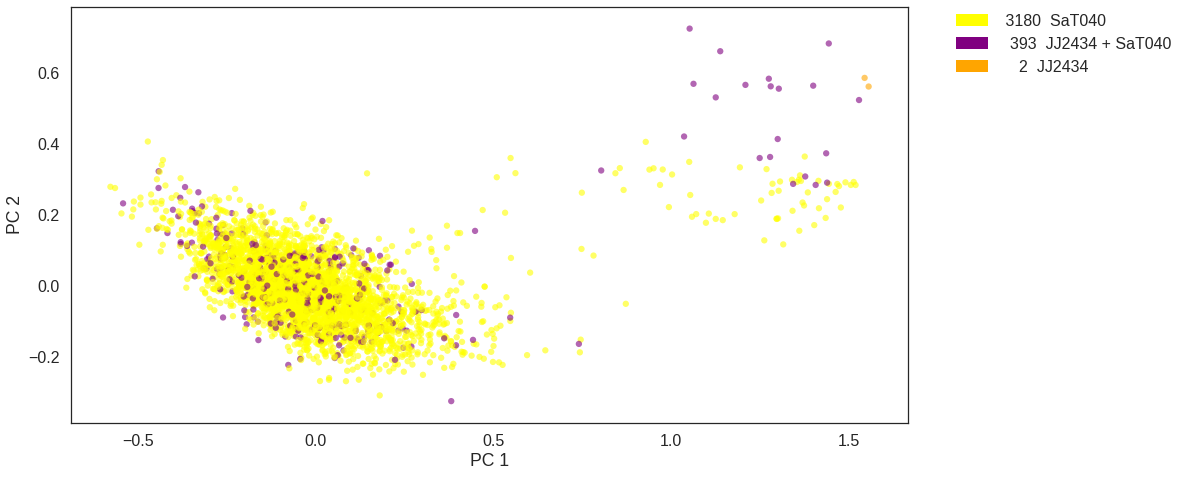

In [54]:
plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names, draw_all=True)

Посмотрим на VAF. Видно, что у нас только один кластер.

In [58]:
print(np.round(np.median(f_withoutT_filtered, axis=0), 2))

[ 0.94  0.84  0.76  0.67  0.57  0.47  0.37  0.26  0.14]


Куда-то все частоты убежали в бОльшую сторону :(